In [ ]:
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from tqdm import tqdm
import camb
from camb import model, initialpower
import warnings 
warnings.filterwarnings('ignore')

In [2]:
sys.path.append("/home/chenzy/code/")
import illustris_python as il

In [3]:
basePath_tng100="/home/cossim/IllustrisTNG/TNG100-1/"
particle_dm_mass=0.00050557*10**10
boxlen_100=75000 #ckpc/h

# read data

## particle

In [18]:
PartPos=il.snapshot.loadSubset(basePath=basePath_tng100, snapNum=99, partType="dm", fields="Coordinates") #168G

In [21]:
del PartPos

## group & subgroup

In [4]:
#Halos
#Group中第一个subhalo对应的坐标
GroupFirstSub=il.groupcat.loadHalos(basePath=basePath_tng100, snapNum=99, fields="GroupFirstSub")
#Group的坐标 ckpc/h
GroupPos=il.groupcat.loadHalos(basePath=basePath_tng100, snapNum=99, fields="GroupPos")
#Group的速度 km/s/a
GroupVel=il.groupcat.loadHalos(basePath=basePath_tng100, snapNum=99, fields="GroupVel")
#mass 200   10^10 M_sun/h
Group_M_Mean200=il.groupcat.loadHalos(basePath=basePath_tng100, snapNum=99, fields="Group_M_Mean200")
# R mean 200 ckpc/h
Group_R_Mean200=il.groupcat.loadHalos(basePath=basePath_tng100, snapNum=99, fields="Group_R_Mean200")


#subhalo
#subhalo的坐标 ckpc/h
SubhaloPos=il.groupcat.loadSubhalos(basePath=basePath_tng100, snapNum=99, fields="SubhaloPos")
#subhalo是否可靠
SubhaloFlag=il.groupcat.loadSubhalos(basePath=basePath_tng100, snapNum=99, fields="SubhaloFlag")
#subhalo 的速度 km/s
SubhaloVel=il.groupcat.loadSubhalos(basePath=basePath_tng100, snapNum=99, fields="SubhaloVel")
# all mass
SubhaloMass=il.groupcat.loadSubhalos(basePath=basePath_tng100, snapNum=99, fields="SubhaloMass")
# mass type
SubhaloMassType=il.groupcat.loadSubhalos(basePath=basePath_tng100, snapNum=99, fields="SubhaloMassType")
SubhaloMass_Star=SubhaloMassType[:,4]

In [ ]:
#对于一个group获得其subhalo的ID
def get_subhaloID(GroupID):
    if GroupFirstSub[GroupID]==-1:
        return 0
    return np.arange(GroupFirstSub[GroupID],GroupFirstSub[GroupID+1])

In [6]:
def get_pos_diff(pos_a,pos_b,boxlen):
    diff1=pos_b-pos_a
    diff2=pos_b-pos_a
    diff2[np.where(np.abs(diff1)>boxlen/2)]=diff1[np.where(np.abs(diff1)>boxlen/2)]-np.sign(diff1[np.where(np.abs(diff1)>boxlen/2)])*boxlen
    return diff2

## offset file 

In [11]:
import h5py
f = h5py.File("/home/cossim/IllustrisTNG/TNG100-1/postprocessing/offsets/offsets_099.hdf5", "r")
pid_group=f["Group/SnapByType"][:]
pid_subhalo=f["Subhalo/SnapByType"][:]
parttype_id={"gas":0,"dm":1,"star":4}
# 在halo粒子表中， subhalo的粒子label
def get_pid_group_subhalo(subgroup_id, group_id, parttype="dm"):
    
    return [pid_subhalo[subgroup_id,parttype_id[parttype]]-pid_group[group_id,parttype_id[parttype]],
            pid_subhalo[subgroup_id+1,parttype_id[parttype]]-pid_group[group_id,parttype_id[parttype]]]

In [99]:
## 测试读粒子的时间
group_id=100
subgroup_id=get_subhaloID(GroupID=group_id)
for j in tqdm(subgroup_id):
    particle_pos=il.snapshot.loadSubhalo(basePath=basePath_tng100, snapNum=99, id=j, partType=partType, fields="Coordinates")

100%|██████████| 854/854 [00:09<00:00, 86.21it/s]


In [102]:
group_id=100
t0=time.time()
particle_pos=il.snapshot.loadHalo(basePath=basePath_tng100, snapNum=99, id=group_id, partType=partType, fields="Coordinates")
print(time.time()-t0)

0.6820385456085205


In [116]:
#验证两种方法得到的结果是一样的
group_id=100
subgroup_id=get_subhaloID(GroupID=group_id)
particle_pos1=il.snapshot.loadSubhalo(basePath=basePath_tng100, snapNum=99, id=subgroup_id[2], partType=partType, fields="Coordinates")

particle_pos2=il.snapshot.loadHalo(basePath=basePath_tng100, snapNum=99, id=group_id, partType=partType, fields="Coordinates")
l1,l2=get_pid_group_subhalo(subgroup_id=subgroup_id[2], group_id=group_id, parttype=1)
particle_pos2=particle_pos2[l1:l2,:]

particle_pos1,particle_pos2

(array([[57604.88063016, 10092.57539977, 39209.85943223],
        [57604.77932261, 10092.62641799, 39209.8366152 ],
        [57604.93801761, 10092.00470572, 39210.1519137 ],
        ...,
        [57580.1788592 , 10119.36496643, 39192.83503224],
        [57599.55356113, 10127.3970679 , 39196.43252349],
        [57602.16558223, 10119.69689964, 39179.07345278]]),
 array([[57604.88063016, 10092.57539977, 39209.85943223],
        [57604.77932261, 10092.62641799, 39209.8366152 ],
        [57604.93801761, 10092.00470572, 39210.1519137 ],
        ...,
        [57580.1788592 , 10119.36496643, 39192.83503224],
        [57599.55356113, 10127.3970679 , 39196.43252349],
        [57602.16558223, 10119.69689964, 39179.07345278]]))

## star mass

In [21]:
subgroup_star_mass=np.load("subgroup_star_mass.npy")

In [241]:
subgroup_star_mass=np.zeros(len(SubhaloMass))
subgroup_star_mass
len(f["Subhalo/SnapByType"][:,4])

4371211

In [248]:
Part_star_mass=il.snapshot.loadSubset(basePath=basePath_tng100, snapNum=99, partType="star", fields="Masses")

In [276]:
subgroup_star_mass=np.zeros(len(SubhaloMass))
for i in tqdm(range(len(SubhaloMass)-1)):
    subgroup_star_mass[i]=np.sum(Part_star_mass[f["Subhalo/SnapByType"][i,4]:f["Subhalo/SnapByType"][i+1,4]])

100%|██████████| 4371210/4371210 [37:31<00:00, 1941.14it/s]


In [277]:
np.save("subgroup_star_mass.npy", subgroup_star_mass)

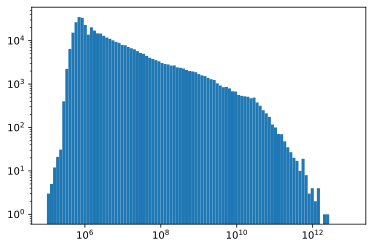

In [290]:
plt.hist(subgroup_star_mass*10**10,bins=10**np.linspace(5,13,100))

plt.xscale("log")
plt.yscale("log")

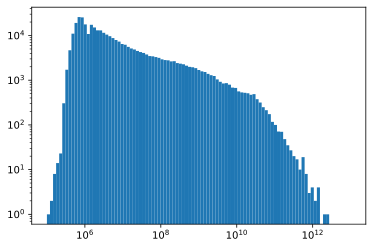

In [81]:
plt.hist(SubhaloMass_Star*10**10,bins=10**np.linspace(5,13,100))

plt.xscale("log")
plt.yscale("log")

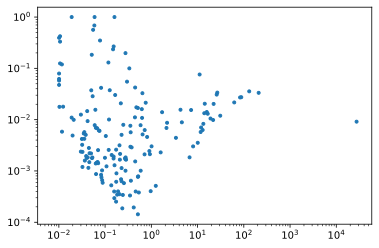

In [274]:
plt.plot(SubhaloMass[:666666:1000],subgroup_star_mass[:666666:1000]/SubhaloMass[:666666:1000],'.')
plt.yscale("log")
plt.xscale("log")

In [87]:
np.sum(subgroup_star_mass>10**0.75*0.7)

1421

# 参考表

## group mass distribution 

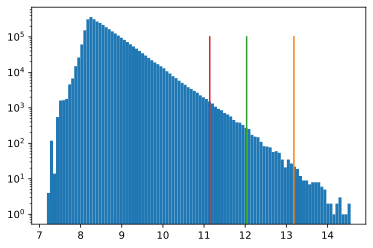

In [206]:
plt.hist(np.log10(Group_M_Mean200[np.where(Group_M_Mean200>0)]*10**10),bins=100)
plt.plot([np.log10(Group_M_Mean200[100])+10,np.log10(Group_M_Mean200[100])+10],[0,100000])
plt.plot([np.log10(Group_M_Mean200[1000])+10,np.log10(Group_M_Mean200[1000])+10],[0,100000])
plt.plot([np.log10(Group_M_Mean200[10000])+10,np.log10(Group_M_Mean200[10000])+10],[0,100000])

plt.yscale("log")

## 比较 group 和 subgroup表中的第一个

它们的位置是一样的

In [197]:
#比较 group 和 subgroup表中的第一个
print("Pos",GroupPos[0,:],SubhaloPos[0])
print("Vel",GroupVel[0],SubhaloVel[0])
print("Mass",Group_M_Mean200[0], SubhaloMass[0])
t0=time.time()
particle_pos_subgroup=il.snapshot.loadSubhalo(basePath=basePath_tng100, snapNum=99, id=0, partType=partType, fields="Coordinates")
print("Read group",time.time()-t0)
t0=time.time()
particle_pos_group=il.snapshot.loadHalo(basePath=basePath_tng100, snapNum=99, id=0, partType=partType, fields="Coordinates")
print("Read one subgroup",time.time()-t0)
print("Number of part", len(particle_pos_group), len(particle_pos_subgroup))
N=0;t0=time.time()
for i in tqdm(range(GroupFirstSub[1])):
    particle_pos_subgroup=il.snapshot.loadSubhalo(basePath=basePath_tng100, snapNum=99, id=i, partType=partType, fields="Coordinates")
    N+=len(particle_pos_subgroup)
print("Number of part", len(particle_pos_group), N)
print("Read all subgroup",time.time()-t0)
#group中的总粒子数的 它的subgroup中的粒子数的和是一样的。但是读取速度（subgroup）很很慢

Pos [  849.09143 26326.996   18306.934  ] [  849.09143 26326.996   18306.934  ]
Vel [  39.46182  -149.21483    31.337929] [  15.84963 -236.39203  -89.52388]
Mass 35478.406 27477.936
Read group 3.9946818351745605


  0%|          | 0/17185 [00:00<?, ?it/s]

Read one subgroup 3.4555132389068604
Number of part 66511903 46136876


100%|██████████| 17185/17185 [04:29<00:00, 63.75it/s]

Number of part 66511903 64906852
Read all subgroup 269.57776069641113


# Velocity profile (subgroups as tracker)

100%|██████████| 3177/3177 [1:16:32<00:00,  1.45s/it]


Text(0, 0.5, 'V/V_200')

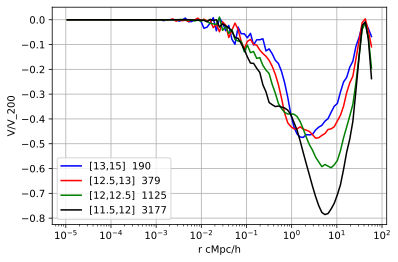

In [75]:
def get_stack_vel_profile(lgM_min,lgM_max,boxlen=boxlen_100, lgr_min=-2, lgr_max=4.8, N_bin_r=100):
    group_id_label=np.where((Group_M_Mean200>10**(lgM_min-10))&(Group_M_Mean200<10**(lgM_max-10)))[0]
    N_group=len(group_id_label)
    
    r_bin=10**np.linspace(lgr_min, lgr_max, N_bin_r)
    vel_stack=np.zeros(len(r_bin)-1)
    for group_id in tqdm(group_id_label):
        group_pos=GroupPos[group_id,:]
        v_200=2.076*10**2*np.sqrt(Group_M_Mean200[group_id]/Group_R_Mean200[group_id])  #km/s

        r_subgroup_group=get_pos_diff(pos_a=group_pos,pos_b=SubhaloPos,boxlen=boxlen)
        r_len=np.sqrt(r_subgroup_group[:,0]**2+r_subgroup_group[:,1]**2+r_subgroup_group[:,2]**2)

        vel_subgroup_group=SubhaloVel-GroupVel[group_id,:]
        vel_r_subgroup_group=np.sum(r_subgroup_group*vel_subgroup_group, axis=1)/r_len
        vel_r_subgroup_group[np.where(r_len==0)]=0 # the group itself is also in the subgroup catalog and need to be excluded

    
        vel_r_mean, edge=np.histogram(r_len, bins=r_bin, weights=vel_r_subgroup_group)
        N, edge=np.histogram(r_len, bins=r_bin)
        vel_r_mean[np.where(N>0)]/=N[np.where(N>0)]
        vel_stack+=vel_r_mean/v_200

    vel_stack/=N_group
    r=(edge[1:]+edge[:-1])/2
    return r, vel_stack, N_group   
def draw_stack_vel_profile(ax, c, lgM_min,lgM_max,boxlen=boxlen_100, lgr_min=-2, lgr_max=4.8, N_bin_r=100):
    
    r, vel_stack, N_group = get_stack_vel_profile(lgM_min=lgM_min,lgM_max=lgM_max,boxlen=boxlen, lgr_min=lgr_min, lgr_max=lgr_max, N_bin_r=N_bin_r)
      
    ax.plot(r/1000, vel_stack, c=c, label="["+str(lgM_min)+","+str(lgM_max)+"]  "+str(N_group))
    
fig,ax=plt.subplots()
draw_stack_vel_profile(ax=ax, c="b", lgM_min=13,lgM_max=15)
draw_stack_vel_profile(ax=ax, c="r", lgM_min=12.5,lgM_max=13)
draw_stack_vel_profile(ax=ax, c="g", lgM_min=12,lgM_max=12.5)
draw_stack_vel_profile(ax=ax, c="k", lgM_min=11.5,lgM_max=12)
ax.legend()
ax.grid()
ax.set_xscale("log")
ax.set_xlabel("r cMpc/h")
ax.set_ylabel("V/V_200")

# save subgroup shape

In [77]:
label=np.where(subgroup_star_mass>10**9/10**10)

## 3D I quad

In [76]:
np.sum(subgroup_star_mass>10**9/10**10)

18663

In [7]:
subgroup_I_dm=np.load("subgroup_I_dm.npy")

In [13]:
N_subhalo=len(SubhaloFlag)
partType="dm"
boxlen=boxlen_100
#subgroup_I_dm=np.zeros((3, 3, N_subhalo))
for i in tqdm(range(18065, 20000)):
    #get subgroups in this group 
    subgroup_id=get_subhaloID(GroupID=i)
    # if there is no subgroup in this halo, then skip it
    if type(subgroup_id)==int:
        continue
        
    #read particle position in this group (for I)
    particle_pos_group=il.snapshot.loadHalo(basePath=basePath_tng100, snapNum=99, id=i, partType=partType, fields="Coordinates")
    
    # relation position of subgroups
    r_subgroup_group=get_pos_diff(pos_a=GroupPos[i,:],pos_b=SubhaloPos,boxlen=boxlen)
    # distance between subgroups and group
    r_len=np.sqrt(r_subgroup_group[:,0]**2+r_subgroup_group[:,1]**2+r_subgroup_group[:,2]**2)

    # relative velocity of subgroups
    vel_subgroup_group=SubhaloVel-GroupVel[i,:]
    # r-direction velocity
    vel_r_subgroup_group=np.sum(r_subgroup_group*vel_subgroup_group, axis=1)/r_len
    vel_r_subgroup_group[np.where(r_len==0)]=0 # the group itself is also in the subgroup catalog and need to be excluded

    
    for j in (subgroup_id):
       
        l1,l2=get_pid_group_subhalo(subgroup_id=j, group_id=i, parttype=partType)
        
            
        # particles in this subgroup
        particle_pos=particle_pos_group[l1:l2,:]
        
        group_pos=GroupPos[i,:]
        subgroup_pos=SubhaloPos[j,:]
        group_vel=GroupVel[i,:]
        subgroup_vel=SubhaloVel[j,:]
        
    
        #particle mass
        if partType=="dm":
            particle_mass=np.ones(len(particle_pos[:,0]))*particle_dm_mass
        else:
            particle_mass=il.snapshot.loadSubhalo(basePath=basePath_tng100, snapNum=99, id=j, partType=partType, fields="Masses")

        pos_diff=get_pos_diff(pos_a=SubhaloPos[j,:],pos_b=particle_pos,boxlen=boxlen)
        I=np.zeros((3,3))
        for ii in range(3):
            for jj in range(3):
                I[ii,jj]=np.sum(particle_mass*pos_diff[:,ii]*pos_diff[:,jj])/np.sum(particle_mass)
        subgroup_I_dm[:,:,j]=I
np.save("subgroup_I_dm.npy", subgroup_I_dm)

100%|██████████| 1935/1935 [21:36<00:00,  1.49it/s]


In [78]:
np.sum(subgroup_I_dm[:,:,label]==0)

10224

## eigenvalue & eigenvector

In [25]:
w=np.zeros((len(subgroup_I_dm[0,0,:]),3))
v=np.zeros((len(subgroup_I_dm[0,0,:]),3,3))
for i in tqdm(range(len(subgroup_I_dm[0,0,:]))):
    I=subgroup_I_dm[:,:,i]

    ww, vv =np.linalg.eig(I)
    ll=(np.argsort(ww)[::-1])
    v[i,:,:]=vv[:,ll]
    w[i,:]=ww[ll]
    

 16%|█▌        | 689976/4371211 [00:19<01:43, 35719.38it/s]


LinAlgError: Array must not contain infs or NaNs

In [28]:
subgroup_I_dm[:,:,439976]

array([[17.36037326,  0.42761702, -0.90975458],
       [ 0.42761702, 11.53971643, -2.65482384],
       [-0.90975458, -2.65482384, 10.2378297 ]])

## 2D e1,e2

In [30]:
def turn_I_into_e(value, vector):
    s_perp=vector[:2,:]
    s_para=vector[2,:]
    
    
    alpha2=0
    k=np.zeros(2)
    W_=np.zeros((2,2))
    for i in [0,1,2]:
        alpha2+=s_para[i]**2/value[i]**2
        
        k[0]+=s_para[i]*s_perp[0,i]/value[i]**2
        k[1]+=s_para[i]*s_perp[1,i]/value[i]**2
        
        W_[0,0]+=s_perp[0,i]*s_perp[0,i]/value[i]**2
        W_[0,1]+=s_perp[0,i]*s_perp[1,i]/value[i]**2
        W_[0,1]+=s_perp[1,i]*s_perp[0,i]/value[i]**2
        W_[1,1]+=s_perp[1,i]*s_perp[1,i]/value[i]**2
        
    W_[0,0]-=k[0]*k[0]/alpha2
    W_[1,0]-=k[1]*k[0]/alpha2
    W_[0,1]-=k[0]*k[1]/alpha2
    W_[1,1]-=k[1]*k[1]/alpha2
    
    W=np.linalg.inv(W_)
    
    e1=(W[0,0]-W[1,1])/(W[0,0]+W[1,1]+2*np.sqrt(np.linalg.det(W)))
    e2=2*W[0,1]/(W[0,0]+W[1,1]+2*np.sqrt(np.linalg.det(W)))
    #print((W[0,0]-W[1,1]), 2*W[0,1], np.sqrt(np.linalg.det(W)))
    
    return np.array([e1,e2])
    

In [19]:
e=np.zeros((2,len(subgroup_I_dm[0,0,:])))
print(len(subgroup_I_dm[0,0,:]))
tan1=[]
tan2=[]
subhalo_choose_flag=np.where(SubhaloMass>1)[0]
for i in tqdm(subhalo_choose_flag):
    
    I=subgroup_I_dm[:,:,i]
    if np.sum(I)==0:
        continue
    w, v =np.linalg.eig(I)
    ll=(np.argsort(w)[::-1])
    v=v[:,ll]
    w=w[ll]
    if w[0]>5*w[1] or any(w<0):continue
    
    a=v[:,0]
    x=a[2]
    y=a[0]
    z=a[1]
    tan1.append(x/y)
    tan2.append(np.sqrt(x**2+y**2)/z)
    

  2%|▏         | 2421/99678 [00:00<00:04, 24203.10it/s]

4371211


100%|██████████| 99678/99678 [00:01<00:00, 50845.47it/s] 


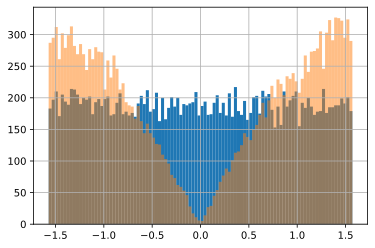

In [57]:
plt.hist(np.arctan(tan1),bins=100)
plt.hist(np.arctan(tan2),bins=100,alpha=0.5)
plt.grid()

In [94]:
e=np.zeros((len(subgroup_I_dm[0,0,:]),2))
print(len(subgroup_I_dm[0,0,:]))
subgroup_star_mass_min=10**10
subgroup_star_mass_max=10**15
subhalo_choose_flag=np.where((subgroup_star_mass>=subgroup_star_mass_min/10**10)&(subgroup_star_mass<=subgroup_star_mass_max/10**10))[0]


for i in tqdm(subhalo_choose_flag):
    
   
    if w[i,0]>5*w[i,1] or any(w[i,:]<=0):continue
    
    e[i,:]=turn_I_into_e(value=w[i,:], vector=v[i,:,:])
    #print(i,subgroup_star_mass[i], SubhaloMass[i],e[i,:], w[i,:])
    #print(np.sqrt(e[0,i]**2+e[1,i]**2))
    #if i == 10 :break
    #if np.abs(e[0,i]/e[1,i])<100 and np.abs(e[0,i]/e[1,i])>0.001:
    #    continue
    #print(i, e ,end="\t\t")

 38%|███▊      | 1940/5053 [00:00<00:00, 19394.10it/s]

4371211


100%|██████████| 5053/5053 [00:00<00:00, 18791.19it/s]


In [32]:
e

array([[-0.15596783, -0.37768286],
       [ 0.18775545,  0.45546214],
       [-0.0304252 , -0.08598632],
       ...,
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

(array([260., 261., 296., 262., 263., 241., 271., 258., 256., 252., 227.,
        286., 262., 236., 212., 218., 208., 210., 228., 185., 210., 186.,
        193., 164., 174., 171., 164., 152., 164., 162., 153., 156., 119.,
        105., 133., 141., 134., 114., 109., 101.,  92., 117.,  80.,  85.,
         85.,  76.,  90.,  64.,  65.,  48.,  70.,  40.,  43.,  43.,  59.,
         35.,  42.,  24.,  41.,  25.,  32.,  26.,  25.,  18.,  34.,  22.,
         17.,  17.,  17.,  11.,  21.,   9.,  10.,  10.,  16.,   9.,   5.,
          3.,   5.,   4.,   0.,   0.,   4.,   5.,   2.,   2.,   2.,   0.,
          0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
        0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
        0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
        0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
        0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24

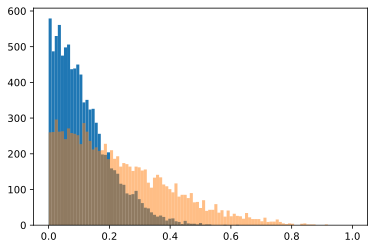

In [40]:
e_len=np.sqrt(e[0,:]**2+e[1,:]**2)
label=np.where(e_len!=0)[0]

plt.hist(e[0,label],bins=np.linspace(0,1,100))
plt.hist(e[1,label],bins=np.linspace(0,1,100), alpha=0.5)
#plt.yscale("log")

### 一些奇形怪状的subhalos

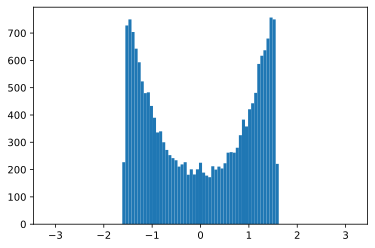

(4352315, 99678)

In [26]:
plt.hist(np.arctan(e[1,subhalo_choose_flag]/e[0,subhalo_choose_flag]),bins=np.linspace(-3.14,3.14,100))
plt.show()
np.sum(e[1,:]==0),len(subhalo_choose_flag)

In [ ]:
4371211
61377 [-1.00000000e+00 -3.54553633e+16]		
76440 [ 1.13333333e+00 -2.81239972e+15]		
76569 [1.00000000e+00 2.51693089e+16]		
108099 [0.00000000e+00 4.85678657e+34]		
114480 [-0.00000000e+00 -2.47349187e+30]		
152256 [-1.0000000e+00 -1.3727996e+17]		
172820 [-1.0000000e+00 -6.0712201e+16]		
245224 [ 1.0000000e+00 -7.8151218e+15]		
281787 [ 1.03174603e+00 -1.52217854e+15]		
294544 [nan nan]		
328019 [-2.53436094e-09  8.53821890e-03]
335946 [-0.00000000e+00 -5.02338557e+32]
359651 [ 1.46153846e+00 -3.52468743e+15]		
412343 [nan nan]		
425754 [0.00000000e+00 1.56739559e+32]		

In [123]:
subhalo_id=77
subhalo_pos = il.snapshot.loadSubhalo(basePath=basePath_tng100, snapNum=99, id=subhalo_id, partType="dm", fields="Coordinates")
subhalo_pos, SubhaloMass[subhalo_id]

(array([[ 1022.08912064, 26017.03323798, 19667.59311129],
        [ 1022.31997824, 26016.85268927, 19667.88725252],
        [ 1022.36813754, 26017.05583645, 19667.56714711],
        ...,
        [  979.63613194, 26077.61411954, 19729.34409621],
        [  954.25160972, 26012.61426469, 19685.29886747],
        [  978.34712896, 26037.14531739, 19588.44987852]]),
 16.899399)

In [131]:
subgroup_I_dm[:,:,77]

array([[ 4.64410963e+02,  3.66417612e-01, -1.35889219e+02],
       [ 3.66417612e-01,  3.80412570e+02, -7.75946065e+00],
       [-1.35889219e+02, -7.75946065e+00,  8.99387574e+02]])

# 验证 

## q=b/a s=c/a 的PDF

279 4371211 4371211


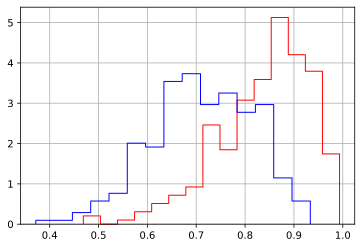

In [280]:
label=np.where((w[:,0]!=0)&(subgroup_star_mass>10**10.75/10**10))[0]

print(len(label), len(w[:,0]), len(SubhaloMass))
plt.hist(np.sqrt(w[label, 1]/w[label, 0]),color="r", bins=15, density=True, histtype="step")
plt.hist(np.sqrt(w[label, 2]/w[label, 0]),color="b", bins=15, density=True, histtype="step")
plt.grid()

664270 4371211 4371211


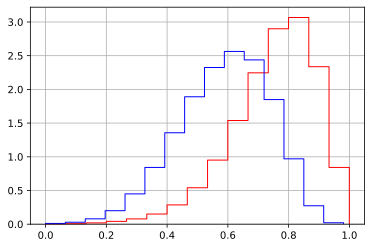

In [281]:
label=np.where((w[:,0]!=0)&(subgroup_star_mass<10**10/10**10))[0]

print(len(label), len(w[:,0]), len(SubhaloMass))
plt.hist(np.sqrt(w[label, 1]/w[label, 0]),color="r", bins=15, density=True, histtype="step")
plt.hist(np.sqrt(w[label, 2]/w[label, 0]),color="b", bins=15, density=True, histtype="step")
plt.grid()

# main

In [131]:
from scipy.spatial import KDTree
subgroup_star_mass_min=10**9*0.7
subgroup_star_mass_max=10**10*0.7
r_bins=10**np.linspace(2,4.3)
label=np.where((subgroup_star_mass>=subgroup_star_mass_min/10**10)&(subgroup_star_mass<=subgroup_star_mass_max/10**10))[0]

subgroup_tree=KDTree(SubhaloPos[label,:], boxsize=boxlen_100)
N_sub_rbins=subgroup_tree.count_neighbors(subgroup_tree,r=r_bins, cumulative=False)
pair_index=subgroup_tree.query_pairs(r=r_bins[-1], output_type="ndarray")

r=get_pos_diff(pos_a=SubhaloPos[label[pair_index[:,1]],:],pos_b=SubhaloPos[label[pair_index[:,0]],:],boxlen=boxlen_100) #b-a
r_len=np.linalg.norm(r, axis=1)

A1=v[label[pair_index[:,0]],:,0]#;a=w[subgroup_id[j],0];b=w[subgroup_id[j],1]
A2=v[label[pair_index[:,1]],:,0]

cos_A_r1=np.sum(A1*r, axis=1)/r_len
cos_A_r2=np.sum(A2*r, axis=1)/r_len


(0.001, 0.3)

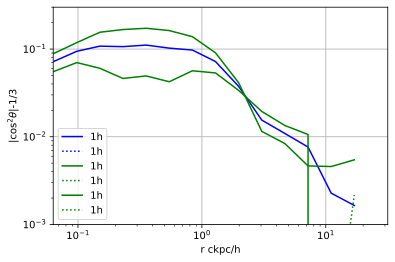

In [132]:
fig,ax=plt.subplots()
r_bins=10**np.linspace(-1.3,1.5,16)

plot_histogram(ax=ax, x=np.hstack([r_len, r_len])/1000, y=np.hstack([cos_A_r1,cos_A_r2])**2-1/3., bins=r_bins, c="b", label=r"1h")
plot_histogram(ax=ax, x=r_len/1000, y=cos_A_r2**2-1/3., bins=r_bins, c="g", label=r"1h")
plot_histogram(ax=ax, x=r_len/1000, y=cos_A_r1**2-1/3., bins=r_bins, c="g", label=r"1h")
#plot_histogram(ax=ax, x=np.hstack([r_len[np.where(cos_e_r1!=0)], r_len[np.where(cos_e_r2!=0)]])/1000, 
               #y=np.hstack([cos_e_r1[np.where(cos_e_r1!=0)], cos_e_r2[np.where(cos_e_r2!=0)]])**2-1/3., bins=r_bins, c="r", label=r"1h")




ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("r ckpc/h")
ax.set_ylabel(r"|cos$^2\theta$|-1/3")
ax.legend(loc=3)
ax.grid()
ax.set_xlim(10**-1.2,10**1.5)
ax.set_ylim(10**-3,0.3)

In [442]:
subgroup_star_mass_min=10**10.75
subgroup_star_mass_max=10**15

label=np.where((subgroup_star_mass>=subgroup_star_mass_min/10**10)&(subgroup_star_mass<=subgroup_star_mass_max/10**10))[0]

print("NUmber of subgroups", len(label))
r=[]
cos_A_r=[]
for i in tqdm(range(len(label))):
    for j in range(i+1, len(label)):
        r_vec=SubhaloPos[label[j],:]-SubhaloPos[label[i],:]
        r_len=np.linalg.norm(r_vec)
        
        A=v[label[j],:,0]#;a=w[subgroup_id[j],0];b=w[subgroup_id[j],1]
        cos_A_r.append(A.dot(r_vec)/r_len)
      
        r.append(r_len)
        
r=np.array(r)/1000
cos_A_r=np.array(cos_A_r)

  2%|▏         | 20/917 [00:00<00:04, 190.48it/s]

NUmber of subgroups 917


100%|██████████| 917/917 [00:02<00:00, 314.10it/s]


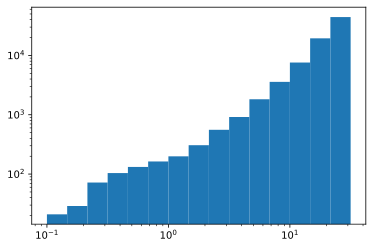

In [443]:
plt.hist(r,bins=r_bins)
plt.xscale("log")
plt.yscale("log")

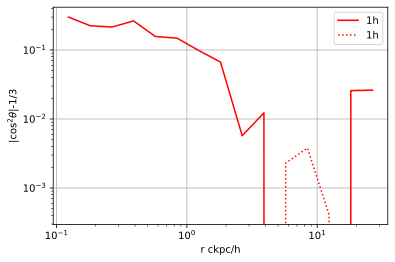

In [326]:
fig,ax=plt.subplots()
r_bins=10**np.linspace(-1,1.5,16)

plot_histogram(ax=ax, x=r, y=np.array(cos_A_r)**2-1/3., bins=r_bins, c="r", label=r"1h")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("r ckpc/h")
ax.set_ylabel(r"|cos$^2\theta$|-1/3")
ax.legend()
ax.grid()
#ax.set_xlim(10**-1.2,10**1.5)
#ax.set_ylim(10**-3,0.3)

In [37]:
def plot_histogram(ax, x, y, bins, c="k", label=""):
    mean,edge=np.histogram(x,bins=bins,weights=y)
    N,edge=np.histogram(x,bins=bins)
    ax.plot((edge[1:]+edge[:-1])/2,mean/N,c, label=label)
    ax.plot((edge[1:]+edge[:-1])/2,-mean/N,c+":", label=label)

In [38]:
def plot_hist_a_N(ax, a, bins=100, c="k", xlabel=""):
    ax.hist(a,bins=bins,c=c)
    
    ax.set_xlabel(xlabel)
    

In [57]:
subgroup_I_dm1=np.load("subgroup_I_dm.npy")

In [67]:
w=np.zeros((3,20000))
for i in tqdm(range(20000)):
    I=subgroup_I_dm[:,:,i]
    if np.sum(I)==0:
        continue
        
    w[:,i], v =np.linalg.eig(I)
w

100%|██████████| 20000/20000 [00:00<00:00, 33041.48it/s]


array([[0.00000000e+00, 6.52337809e+04, 3.58331029e+03, ...,
        7.51884444e+00, 1.48971600e+01, 3.74939597e+00],
       [0.00000000e+00, 3.58669130e+04, 4.11207598e+03, ...,
        9.36755171e+00, 3.97549350e+01, 4.96289067e+00],
       [0.00000000e+00, 2.98192211e+04, 3.94363540e+03, ...,
        1.06243703e+01, 4.59473273e+01, 7.05748277e+00]])

In [141]:
group_mass_max=10**15
group_mass_min=10**13
partType="dm"
boxlen=boxlen_100

N_group=len(np.where((Group_M_Mean200>group_mass_min/10**10) & (Group_M_Mean200<group_mass_max/10**10))[0])
print("number of groups",N_group)
#cos=[]
#r_group_sub=[]
#sub_vel=[]
#vel_elli=[]
#a_b=[]
N_useless1=0
N_useless2=0

r=[]
V_r=[]
V_len=[]
a_b=[]
cos_A_V=[]
cos_A_r=[]
main_halo_mass=[]
self_mass=[]
main_halo_r200=[]
cos_e_r=[]
cos_e_v=[]

for i in tqdm(range(N_group)):
    #get subgroups in this group 
    subgroup_id=get_subhaloID(GroupID=i)
    # if there is no subgroup in this halo, then skip it
    if type(subgroup_id)==int:
        continue
        
    
    # relation position of subgroups
    r_subgroup_group=get_pos_diff(pos_a=GroupPos[i,:],pos_b=SubhaloPos,boxlen=boxlen)
    # distance between subgroups and group
    r_len=np.sqrt(r_subgroup_group[:,0]**2+r_subgroup_group[:,1]**2+r_subgroup_group[:,2]**2)
    
    # relative velocity of subgroups
    vel_subgroup_group=SubhaloVel-GroupVel[i,:]
    # r-direction velocity
    vel_r_subgroup_group=np.sum(r_subgroup_group*vel_subgroup_group, axis=1)/r_len
    vel_r_subgroup_group[np.where(r_len==0)]=0 # the group itself is also in the subgroup catalog and need to be excluded

   
    for j in (subgroup_id):
        I=subgroup_I_dm[:,:,j]
        if np.sum(I)==0:
            continue
        
        w, v =np.linalg.eig(I)
        ll=(np.argsort(w)[::-1])
        v=v[:,ll]
        w=w[ll]
        if w[0]>5*w[1] or any(w<0):continue
        
        A=v[:,0];a=w[0];b=w[1]
        
        r.append(r_len[j])
        V_r.append(vel_r_subgroup_group[j])
        V_len.append(np.linalg.norm(vel_subgroup_group[j,:]))
        a_b.append(a/b)
        cos_A_V.append(A.dot(vel_subgroup_group[j,:])/np.linalg.norm(vel_subgroup_group[j,:]))
        cos_A_r.append(A.dot(r_subgroup_group[j,:])/r_len[j])
        main_halo_mass.append(Group_M_Mean200[i])
        self_mass.append(Group_R_Mean200[i])
        main_halo_r200.append(SubhaloMass[j])
        
        cos_e_r.append((e[0,j]*r_subgroup_group[j,0]+e[1,j]*r_subgroup_group[j,1])
                       /np.sqrt(r_subgroup_group[j,0]**2+r_subgroup_group[j,1]**2)
                       /np.sqrt(e[0,j]**2+e[1,j]**2))
        cos_e_v.append((e[0,j]*vel_subgroup_group[j,0]+e[1,j]*vel_subgroup_group[j,1])
                       /np.sqrt(vel_subgroup_group[j,0]**2+vel_subgroup_group[j,1]**2
                                /np.sqrt(e[0,j]**2+e[1,j]**2)))
        
r=np.array(r)/1000
V_r=np.array(V_r)
V_len=np.array(V_len)
a_b=np.array(a_b)
cos_A_V=np.array(cos_A_V)
cos_A_r=np.array(cos_A_r)
V_tan_len=np.sqrt(V_len**2-V_r**2)
main_halo_mass=np.array(main_halo_mass)
self_mass=np.array(self_mass)
main_halo_r200=np.array(main_halo_r200)



  0%|          | 0/190 [00:00<?, ?it/s]

number of groups 190


100%|██████████| 190/190 [02:12<00:00,  1.44it/s]


## 1h-term & 2h-term 

In [298]:
group_mass_max=10**15
group_mass_min=10**13
subhalomass_min=10**12
subgroup_star_mass=10**9
partType="dm"
boxlen=boxlen_100
r_max=2*10**4

N_group=len(np.where((Group_M_Mean200>group_mass_min/10**10) & (Group_M_Mean200<group_mass_max/10**10))[0])
print("number of groups", N_group)

r_1h=[];r_2h=[]
V_r_1h=[];V_r_2h=[]
V_len_1h=[];V_len_2h=[]
a_b_1h=[];a_b_2h=[]
cos_A_V_1h=[];cos_A_V_2h=[]
cos_A_r_1h=[];cos_A_r_2h=[]

main_halo_mass=[]
self_mass=[]
main_halo_r200=[]
cos_e_r=[]
cos_e_v=[]

sub_1h_all=0
#choose suitable subhalos 1
subgroup_id_choose1=np.where((np.sum(subgroup_I_dm.reshape(9,-1), axis=0)!=0) & (subgroup_star_mass > subgroup_star_mass/10**10) )[0]
for i in tqdm(range(N_group)):
    
    # relation position of subgroups
    r_subgroup_group=get_pos_diff(pos_a=GroupPos[i,:],pos_b=SubhaloPos[subgroup_id_choose1,:],boxlen=boxlen)

    # distance between subgroups and group
    r_len=np.sqrt(r_subgroup_group[:,0]**2+r_subgroup_group[:,1]**2+r_subgroup_group[:,2]**2)
    
    ##choose suitable subhalos 2
    label=np.where(r_len<r_max)
    subgroup_id=subgroup_id_choose1[label]
    r_subgroup_group=r_subgroup_group[label]
    r_len=r_len[label]
    
    # relative velocity of subgroups
    vel_subgroup_group=SubhaloVel[subgroup_id,:]-GroupVel[i,:]
    # r-direction velocity
    vel_r_subgroup_group=np.sum(r_subgroup_group*vel_subgroup_group, axis=1)/r_len
    vel_r_subgroup_group[np.where(r_len==0)]=0 # the group itself is also in the subgroup catalog and need to be excluded
    vel_len=np.linalg.norm(vel_subgroup_group, axis=1)
    
    # get which particles belong to 1h-term
    id_1h = get_subhaloID(GroupID=i)
    sub_1h_all+=len(id_1h)
    if type(subgroup_id)==int:
        id_1h_min=0;id_1h_max=0
    else:
        id_1h_min=id_1h[0];id_1h_max=id_1h[-1]
    

    for j in (range(len(subgroup_id))):
        #if r_len[j]>r_max:continue
        #I=subgroup_I_dm[:,:,subgroup_id[j]]
       
        
        #w, v =np.linalg.eig(I)
        #ll=(np.argsort(w)[::-1])
        #v=v[:,ll]
        #w=w[ll]
        if w[subgroup_id[j],0]>5*w[subgroup_id[j],1] or any(w[subgroup_id[j],:]<0):continue
        
        
        A=v[subgroup_id[j],:,0];a=w[subgroup_id[j],0];b=w[subgroup_id[j],1]
        
        if subgroup_id[j]>=id_1h_min and subgroup_id[j]<=id_1h_max:
            #print(subgroup_id[j], A, vel_subgroup_group[j,:])
            r_1h.append(r_len[j])
            V_r_1h.append(vel_r_subgroup_group[j])
            V_len_1h.append(vel_len[j])
            a_b_1h.append(a/b)
            cos_A_V_1h.append(A.dot(vel_subgroup_group[j,:])/vel_len[j])
            cos_A_r_1h.append(A.dot(r_subgroup_group[j,:])/r_len[j])
        else:
            r_2h.append(r_len[j])
            V_r_2h.append(vel_r_subgroup_group[j])
            V_len_2h.append(vel_len[j])
            a_b_2h.append(a/b)
            cos_A_V_2h.append(A.dot(vel_subgroup_group[j,:])/vel_len[j])
            cos_A_r_2h.append(A.dot(r_subgroup_group[j,:])/r_len[j])
            
        continue
        
        main_halo_mass.append(Group_M_Mean200[i])
        self_mass.append(Group_R_Mean200[i])
        main_halo_r200.append(SubhaloMass[subgroup_id[j]])
        
        cos_e_r.append((e[0,subgroup_id[j]]*r_subgroup_group[j,0]+e[1,subgroup_id[j]]*r_subgroup_group[j,1])
                       /np.sqrt(r_subgroup_group[j,0]**2+r_subgroup_group[j,1]**2))
        cos_e_v.append((e[0,subgroup_id[j]]*vel_subgroup_group[j,0]+e[1,subgroup_id[j]]*vel_subgroup_group[j,1])
                       /np.sqrt(vel_subgroup_group[j,0]**2+vel_subgroup_group[j,1]**2))

r_1h=np.array(r_1h)/1000; r_2h=np.array(r_2h)/1000
V_r_1h=np.array(V_r_1h); V_r_2h=np.array(V_r_2h)
V_len_1h=np.array(V_len_1h); V_len_2h=np.array(V_len_2h)

r=np.array(r)/1000
V_r=np.array(V_r)
V_len=np.array(V_len)
a_b=np.array(a_b)
cos_A_V=np.array(cos_A_V)
cos_A_r=np.array(cos_A_r)
V_tan_len=np.sqrt(V_len**2-V_r**2)
main_halo_mass=np.array(main_halo_mass)
self_mass=np.array(self_mass)
main_halo_r200=np.array(main_halo_r200)

print(sub_1h_all)

number of groups 190


100%|██████████| 190/190 [01:31<00:00,  2.07it/s]


316665


305699 11888630 305699


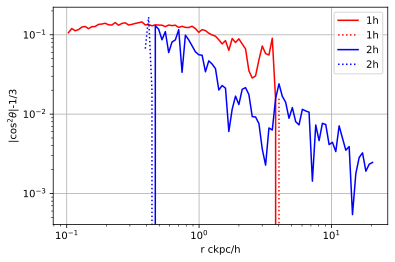

In [299]:
fig,ax=plt.subplots()
r_bins=10**np.linspace(-1,1.5,100)
print(len(r_1h), len(r_2h), len(r))
plot_histogram(ax=ax, x=r_1h, y=np.array(cos_A_r_1h)**2-1/3., bins=r_bins, c="r", label=r"1h")
plot_histogram(ax=ax, x=r_2h, y=np.array(cos_A_r_2h)**2-1/3., bins=r_bins, c="b", label=r"2h")


ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("r ckpc/h")
ax.set_ylabel(r"|cos$^2\theta$|-1/3")
ax.legend()
ax.grid()
#ax.set_xlim(10**-1.2,10**1.5)
#ax.set_ylim(10**-3,0.3)

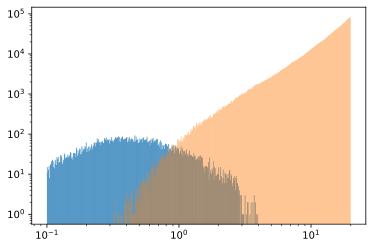

In [203]:
plt.hist(r_1h,bins=10**np.linspace(-1,1.3,500))
plt.hist(r_2h,bins=10**np.linspace(-1,1.3,500),alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.show()

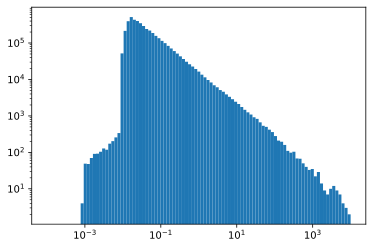

In [184]:
plt.hist(SubhaloMass,bins=10**np.linspace(-4,4,100))
plt.xscale("log")
plt.yscale("log")

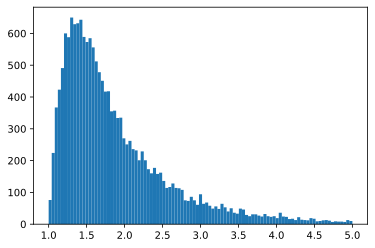

In [69]:
plt.hist(np.array(a_b),bins=np.linspace(1,5,100))
plt.show()

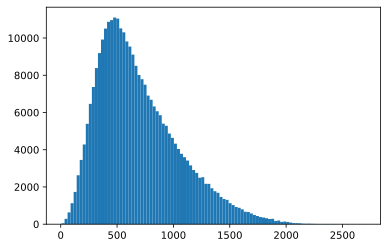

In [126]:
plt.hist(np.array(V_len),bins=100)
plt.show()

In [200]:
print(len(r))

305699


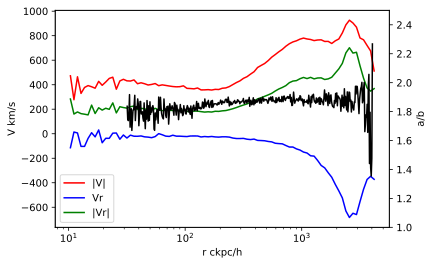

In [73]:
fig,ax=plt.subplots()
r_bins=10**np.linspace(1,4,100)
axx=ax.twinx()

plot_histogram(ax=axx, x=r, y=a_b, bins=10**np.linspace(1.5,4,500), c="k", label="a/b")
plot_histogram(ax=ax, x=r, y=V_len, bins=r_bins, c="r", label="|V|")
plot_histogram(ax=ax, x=r, y=V_r, bins=r_bins, c="b", label="Vr")
plot_histogram(ax=ax, x=r, y=np.abs(V_r), bins=r_bins, c="g", label="|Vr|")

ax.set_xscale("log")
axx.set_ylim(1,2.5)
ax.set_xlabel("r ckpc/h")
ax.set_ylabel("V km/s")
axx.set_ylabel("a/b")
ax.legend(loc=3)

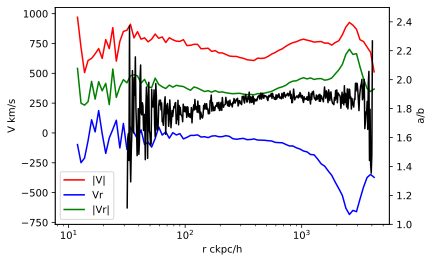

In [169]:
fig,ax=plt.subplots()
r_bins=10**np.linspace(1,4,100)
axx=ax.twinx()

plot_histogram(ax=axx, x=r, y=a_b, bins=10**np.linspace(1.5,4,500), c="k", label="a/b")
plot_histogram(ax=ax, x=r, y=V_len, bins=r_bins, c="r", label="|V|")
plot_histogram(ax=ax, x=r, y=V_r, bins=r_bins, c="b", label="Vr")
plot_histogram(ax=ax, x=r, y=np.abs(V_r), bins=r_bins, c="g", label="|Vr|")

ax.set_xscale("log")
axx.set_ylim(1,2.5)
ax.set_xlabel("r ckpc/h")
ax.set_ylabel("V km/s")
axx.set_ylabel("a/b")
ax.legend(loc=3)

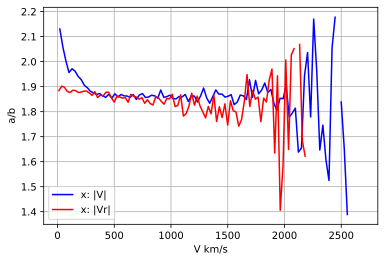

In [171]:
fig,ax=plt.subplots()
r_bins=10**np.linspace(1,4,20)
#axx=ax.twinx()


plot_histogram(ax=ax, x=V_len, y=a_b, bins=100, c="b", label="x: |V|")
plot_histogram(ax=ax, x=np.abs(V_r), y=a_b, bins=100, c="r", label="x: |Vr|")
#plot_histogram(ax=ax, x=r, y=V_r, bins=r_bins, c="b")
#plot_histogram(ax=ax, x=r, y=np.abs(V_r), bins=r_bins, c="g")

#ax.set_xscale("log")
#axx.set_ylim(1,4)
ax.set_ylabel("a/b")
ax.set_xlabel("V km/s")
ax.grid()
ax.legend()

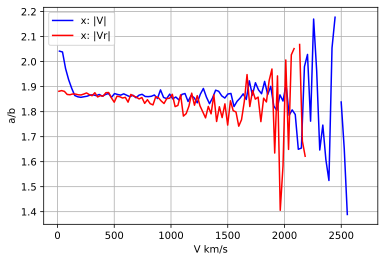

In [77]:
fig,ax=plt.subplots()
r_bins=10**np.linspace(1,4,20)
#axx=ax.twinx()


plot_histogram(ax=ax, x=V_len, y=a_b, bins=100, c="b", label="x: |V|")
plot_histogram(ax=ax, x=np.abs(V_r), y=a_b, bins=100, c="r", label="x: |Vr|")
#plot_histogram(ax=ax, x=r, y=V_r, bins=r_bins, c="b")
#plot_histogram(ax=ax, x=r, y=np.abs(V_r), bins=r_bins, c="g")

#ax.set_xscale("log")
#axx.set_ylim(1,4)
ax.set_ylabel("a/b")
ax.set_xlabel("V km/s")
ax.grid()
ax.legend()

In [16]:
len(r)

463909

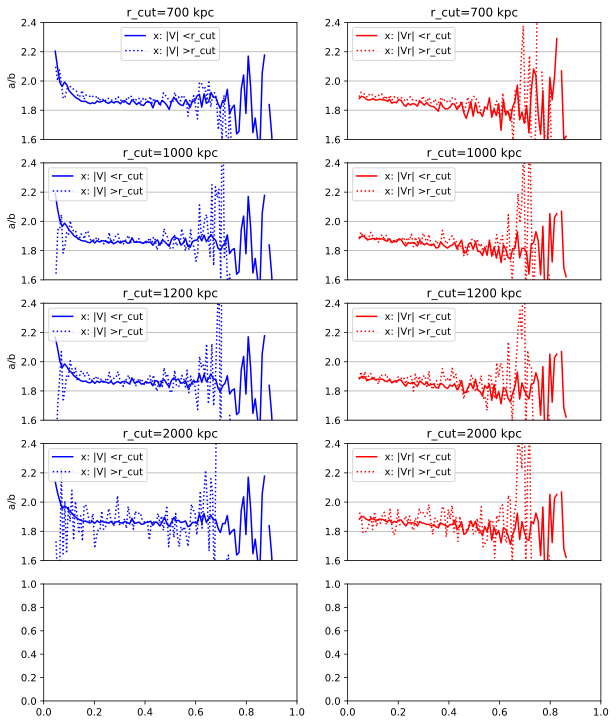

In [226]:
fig,ax=plt.subplots(5,2,figsize=(2*5, 5*2.5))
r_bins=10**np.linspace(1,4,20)
#axx=ax.twinx()
r=np.array(r)
V_len=np.array(V_len)
a_b=np.array(a_b)
V_r=np.array(V_r)
i=0
for r_cut in [700,1000,1200,2000]:
    label1=np.where(r<=r_cut)
    label2=np.where(r>r_cut)
    plot_histogram(ax=ax[i,0], x=V_len[label1], y=a_b[label1], bins=100, c="b", label="x: |V| <r_cut")
    plot_histogram(ax=ax[i,1], x=np.abs(V_r[label1]), y=a_b[label1], bins=100, c="r", label="x: |Vr| <r_cut")
    
    plot_histogram(ax=ax[i,0], x=V_len[label2], y=a_b[label2], bins=100, c="b:", label="x: |V| >r_cut")
    plot_histogram(ax=ax[i,1], x=np.abs(V_r[label2]), y=a_b[label2], bins=100, c="r:", label="x: |Vr| >r_cut")
    for j in [0,1]:
        ax[i,j].set_ylim(1.6,2.4)
        ax[i,j].grid()
        ax[i,0].set_ylabel("a/b")
        #ax[i,j].set_xlabel("V km/s")
        ax[i,j].legend()
        ax[i,j].set_xticks([])
        ax[i,j].set_title("r_cut="+str(r_cut)+" kpc")
    i+=1



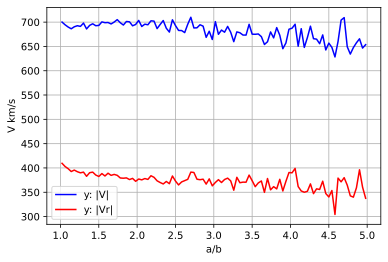

In [199]:
fig,ax=plt.subplots()
r_bins=10**np.linspace(1,4,20)
#axx=ax.twinx()


plot_histogram(ax=ax, x=a_b, y=V_len, bins=100, c="b", label="y: |V|")
plot_histogram(ax=ax, x=a_b, y=np.abs(V_r), bins=100, c="r", label="y: |Vr|")
#plot_histogram(ax=ax, x=r, y=V_r, bins=r_bins, c="b")
#plot_histogram(ax=ax, x=r, y=np.abs(V_r), bins=r_bins, c="g")

#ax.set_xscale("log")
#axx.set_ylim(1,4)
ax.set_xlabel("a/b")
ax.set_ylabel("V km/s")
ax.grid()
ax.legend()

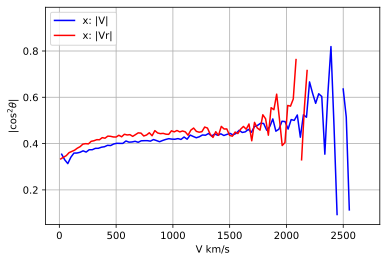

In [197]:
fig,ax=plt.subplots()
r_bins=10**np.linspace(1,4,20)
#axx=ax.twinx()


plot_histogram(ax=ax, x=V_len, y=np.array(cos_A_V)**2, bins=100, c="b", label="x: |V|")
plot_histogram(ax=ax, x=np.abs(V_r), y=np.array(cos_A_V)**2, bins=100, c="r", label="x: |Vr|")
#plot_histogram(ax=ax, x=r, y=V_r, bins=r_bins, c="b")
#plot_histogram(ax=ax, x=r, y=np.abs(V_r), bins=r_bins, c="g")

#ax.set_xscale("log")
#axx.set_ylim(1,4)
ax.set_ylabel(r"|cos$^2\theta$|")
ax.set_xlabel("V km/s")
ax.grid()
ax.legend()

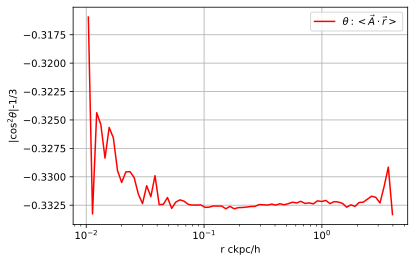

In [73]:
fig,ax=plt.subplots()
r_bins=10**np.linspace(-2,1.5,100)
cos_e_r=np.array(cos_e_v)
label=np.where(cos_e_r>-10)
plot_histogram(ax=ax, x=r[label], y=np.array(cos_e_r[label])**2-1/3., bins=r_bins, c="r", label=r"$\theta:< \vec A\cdot \vec r>$")
#plot_histogram(ax=ax, x=r, y=np.array(cos_A_V)**2-1/3., bins=r_bins, c="b", label=r"$\theta:< \vec A\cdot \vec V>$")
#plot_histogram(ax=ax, x=r, y=np.array(V_r/V_len)**2-1/3., bins=r_bins, c="g", label=r"$\theta:< \vec V\cdot \vec r>$")
#plot_histogram(ax=ax, x=r, y=np.abs(V_r), bins=r_bins, c="g")
#ax.plot(r_bins,np.ones(len(r_bins))*0.1666,":k")
ax.set_xscale("log")
#ax.set_yscale("log")

ax.set_xlabel("r ckpc/h")
ax.set_ylabel(r"|cos$^2\theta$|-1/3")
ax.legend()
ax.grid()
#ax.set_xlim(10**-1.2,10**1.5)

In [67]:
cos_e_r

array([nan, nan, nan, ..., nan, nan, nan])

(0.06309573444801933, 31.622776601683793)

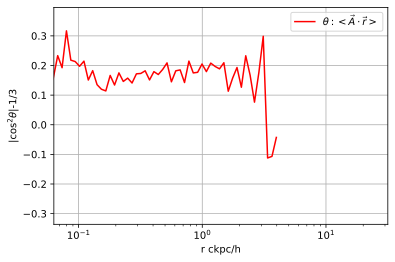

In [31]:
fig,ax=plt.subplots()
r_bins=10**np.linspace(-2,1.5,100)

plot_histogram(ax=ax, x=r[label], y=np.array(cos_e_r[label])**2-1/3., bins=r_bins, c="r", label=r"$\theta:< \vec A\cdot \vec r>$")
#plot_histogram(ax=ax, x=r, y=np.array(cos_A_V)**2-1/3., bins=r_bins, c="b", label=r"$\theta:< \vec A\cdot \vec V>$")
#plot_histogram(ax=ax, x=r, y=np.array(V_r/V_len)**2-1/3., bins=r_bins, c="g", label=r"$\theta:< \vec V\cdot \vec r>$")
#plot_histogram(ax=ax, x=r, y=np.abs(V_r), bins=r_bins, c="g")
#ax.plot(r_bins,np.ones(len(r_bins))*0.1666,":k")
ax.set_xscale("log")
#ax.set_yscale("log")

ax.set_xlabel("r ckpc/h")
ax.set_ylabel(r"|cos$^2\theta$|-1/3")
ax.legend()
ax.grid()
ax.set_xlim(10**-1.2,10**1.5)

In [29]:
cos_e_r=np.array(cos_e_r)
label=np.where(cos_e_r>-10)
np.array(cos_e_r[label])**2-1/3.

array([ 0.66617322,  0.56165901,  0.25871608, ..., -0.31090085,
       -0.27681241,  0.11690867])

(0.06309573444801933, 31.622776601683793)

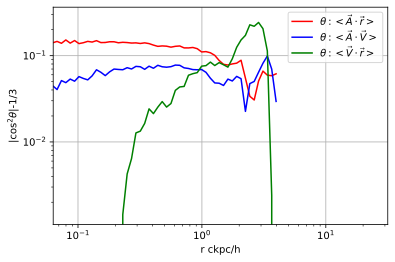

In [87]:
fig,ax=plt.subplots()
r_bins=10**np.linspace(-2,1.5,100)

plot_histogram(ax=ax, x=r, y=np.array(cos_A_r)**2-1/3., bins=r_bins, c="r", label=r"$\theta:< \vec A\cdot \vec r>$")
plot_histogram(ax=ax, x=r, y=np.array(cos_A_V)**2-1/3., bins=r_bins, c="b", label=r"$\theta:< \vec A\cdot \vec V>$")
plot_histogram(ax=ax, x=r, y=np.array(V_r/V_len)**2-1/3., bins=r_bins, c="g", label=r"$\theta:< \vec V\cdot \vec r>$")
#plot_histogram(ax=ax, x=r, y=np.abs(V_r), bins=r_bins, c="g")
#ax.plot(r_bins,np.ones(len(r_bins))*0.1666,":k")
ax.set_xscale("log")
ax.set_yscale("log")
axx.set_ylim(1,4)
ax.set_xlabel("r ckpc/h")
ax.set_ylabel(r"|cos$^2\theta$|-1/3")
ax.legend()
ax.grid()
ax.set_xlim(10**-1.2,10**1.5)

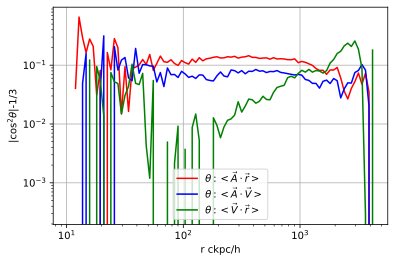

In [227]:
fig,ax=plt.subplots()
r_bins=10**np.linspace(1,4,100)

plot_histogram(ax=ax, x=r, y=np.array(cos_A_r)**2-1/3., bins=r_bins, c="r", label=r"$\theta:< \vec A\cdot \vec r>$")
plot_histogram(ax=ax, x=r, y=np.array(cos_A_V)**2-1/3., bins=r_bins, c="b", label=r"$\theta:< \vec A\cdot \vec V>$")
plot_histogram(ax=ax, x=r, y=np.array(V_r/V_len)**2-1/3., bins=r_bins, c="g", label=r"$\theta:< \vec V\cdot \vec r>$")
#plot_histogram(ax=ax, x=r, y=np.abs(V_r), bins=r_bins, c="g")
#ax.plot(r_bins,np.ones(len(r_bins))*0.1666,":k")
ax.set_xscale("log")
ax.set_yscale("log")
axx.set_ylim(1,4)
ax.set_xlabel("r ckpc/h")
ax.set_ylabel(r"|cos$^2\theta$|-1/3")
ax.legend()
ax.grid()

In [178]:
cos_mean

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])

In [180]:
cos=np.array(cos)
cos_=np.array(cos_)
cos_=cos_[np.where(cos_>-1)]
vel_elli=np.array(vel_elli)
vel_elli_mean,a=np.histogram(r_group_sub,bins=np.linspace(0,5000,100),weights=np.abs(vel_elli**2))
cos_mean,a=np.histogram(r_group_sub,bins=np.linspace(0,5000,100),weights=np.abs(cos_**2))
N,a=np.histogram(r_group_sub,bins=np.linspace(0,5000,100))
print(N, len(cos))
cos_mean/=N
vel_elli_mean/=N
plt.plot(a[1:], cos_mean-1/3.)
plt.plot(a[1:], vel_elli_mean-1/3.)



ValueError: weights should have the same shape as a.

(array([ 6.,  8., 15., 21., 21., 22., 22., 17., 24., 11.]),
 array([0.02155825, 0.29957829, 0.57759832, 0.85561835, 1.13363838,
        1.41165842, 1.68967845, 1.96769848, 2.24571851, 2.52373854,
        2.80175858]),
 <BarContainer object of 10 artists>)

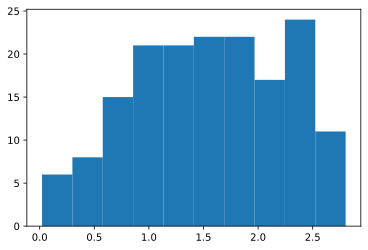

In [76]:
plt.hist(np.arccos(cos))

In [64]:
v,v[0],v[:,0]

(array([[-0.33721849, -0.89156044,  0.3023304 ],
        [-0.61133039, -0.03684053, -0.7905175 ],
        [-0.71593215,  0.45140088,  0.53261469]]),
 array([-0.33721849, -0.89156044,  0.3023304 ]),
 array([-0.33721849, -0.61133039, -0.71593215]))

In [30]:
w, v =np.linalg.eig(I)
w,v, v[:,0]

(array([792056.11288486,   2850.58052564,   2351.42673635]),
 array([[-0.00743738, -0.8944505 ,  0.44710513],
        [-0.44908984,  0.40247837,  0.79770262],
        [ 0.89345565,  0.19485755,  0.40468202]]),
 array([-0.00743738, -0.44908984,  0.89345565]))

# backup

In [ ]:
group_mass_max=10**15
group_mass_min=10**13
partType="dm"
boxlen=boxlen_100

N_group=len(np.where((Group_M_Mean200>group_mass_min/10**10) & (Group_M_Mean200<group_mass_max/10**10))[0])
print("number of groups",N_group)
#cos=[]
#r_group_sub=[]
#sub_vel=[]
#vel_elli=[]
#a_b=[]
N_useless1=0
N_useless2=0

r=[]
V_r=[]
V_len=[]
a_b=[]
cos_A_V=[]
cos_A_r=[]


for i in tqdm(range(N_group)):
    #get subgroups in this group 
    subgroup_id=get_subhaloID(GroupID=i)
    # if there is no subgroup in this halo, then skip it
    if type(subgroup_id)==int:
        continue
        
    #read particle position in this group (for I)
    particle_pos_group=il.snapshot.loadHalo(basePath=basePath_tng100, snapNum=99, id=i, partType=partType, fields="Coordinates")

    
    
    # relation position of subgroups
    r_subgroup_group=get_pos_diff(pos_a=GroupPos[i,:],pos_b=SubhaloPos,boxlen=boxlen)
    # distance between subgroups and group
    r_len=np.sqrt(r_subgroup_group[:,0]**2+r_subgroup_group[:,1]**2+r_subgroup_group[:,2]**2)

    # relative velocity of subgroups
    vel_subgroup_group=SubhaloVel-GroupVel[i,:]
    # r-direction velocity
    vel_r_subgroup_group=np.sum(r_subgroup_group*vel_subgroup_group, axis=1)/r_len
    vel_r_subgroup_group[np.where(r_len==0)]=0 # the group itself is also in the subgroup catalog and need to be excluded

    
    for j in (subgroup_id):
        if SubhaloFlag[j]==0: 
            N_useless1+=1
            continue
        l1,l2=get_pid_group_subhalo(subgroup_id=j, group_id=i, parttype=partType)
        if l2==l1: 
            N_useless2+=1
            continue
            
        # particles in this subgroup
        particle_pos=particle_pos_group[l1:l2,:]
        
        group_pos=GroupPos[i,:]
        subgroup_pos=SubhaloPos[j,:]
        group_vel=GroupVel[i,:]
        subgroup_vel=SubhaloVel[j,:]
        
    
        #particle mass
        if partType=="dm":
            particle_mass=np.ones(len(particle_pos[:,0]))*particle_dm_mass
        else:
            particle_mass=il.snapshot.loadSubhalo(basePath=basePath_tng100, snapNum=99, id=j, partType=partType, fields="Masses")

        pos_diff=get_pos_diff(pos_a=SubhaloPos[j,:],pos_b=particle_pos,boxlen=boxlen)
        I=np.zeros((3,3))
        for ii in range(3):
            for jj in range(3):
                I[ii,jj]=np.sum(particle_mass*pos_diff[:,ii]*pos_diff[:,jj])/np.sum(particle_mass)

        w, v =np.linalg.eig(I)
        ll=(np.argsort(w)[::-1])
        v=v[:,ll]
        w=w[ll]
        if w[0]>5*w[1] or any(w<0):continue
        
        
        A=v[:,0];a=w[0];b=w[1]
        
        
        r.append(r_len[j])
        V_r.append(vel_r_subgroup_group[j])
        V_len.append(np.linalg.norm(vel_subgroup_group[j,:]))
        a_b.append(a/b)
        cos_A_V.append(A.dot(vel_subgroup_group[j,:])/np.linalg.norm(vel_subgroup_group[j,:]))
        cos_A_r.append(A.dot(r_subgroup_group[j,:])/r_len[j])
        
        
r=np.array(r)
V_r=np.array(V_r)
V_len=np.array(V_len)
a_b=np.array(a_b)
cos_A_V=np.array(cos_A_V)
cos_A_r=np.array(cos_A_r)
V_tan_len=np.sqrt(V_len**2-V_r**2)


  0%|          | 0/190 [00:00<?, ?it/s]

number of groups 190
